In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import dandelion as ddl
import os
import tools

sc.logging.print_header()

os.chdir(os.path.expanduser('/home/jovyan/Zach/scanpy/'))

scanpy==1.8.2 anndata==0.7.6 umap==0.5.1 numpy==1.21.6 scipy==1.5.2 pandas==1.3.5 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.8.3 leidenalg==0.8.2 pynndescent==0.5.2


In [2]:
ddl.logging.print_header()

dandelion==0.2.4 pandas==1.3.5 numpy==1.21.6 matplotlib==3.5.2 networkx==2.5 scipy==1.5.2


In [3]:
# just do naive only and split up each tissue
adata_list = []

samples = ["LN", "Men", "LN2", "Men2"]
condition = ["naive", "VSV"]
site_dict = {"LN": "LN", "Men": "Meninges", "LN2": "LN", "Men2": "Meninges"}
sequencing_batch_dict = {"LN": "1", "Men": "1", "LN2": "2", "Men2": "2"}
file_dict = {
    "LN_naive": "LN_naive",
    "Men_naive": "Men_naive",
    "LN2_naive": "PBS_LN",
    "Men2_naive": "PBS_HUB",
    "LN_VSV": "LN_VSV",
    "Men_VSV": "Men_VSV",
    "LN2_VSV": "VSV_LN_2",
    "Men2_VSV": "VSV_HUB",
}

for s in samples:
    for c in condition:
        adatax = sc.read_10x_h5(
            "../raw/"
            + s
            + "_"
            + c
            + "_outs/"
            + file_dict[s + "_" + c]
            + "_filtered_feature_bc_matrix.h5"
        )
        adatax.var_names_make_unique()
        adatax.obs["sample_id"] = s + "_" + c
        adatax.obs["condition"] = c
        adatax.obs["site"] = site_dict[s]
        adatax.obs["sequencing_batch"] = sequencing_batch_dict[s]
        adatax.obs_names = [
            file_dict[s + "_" + c] + "_" + n for n in adatax.obs_names
        ]
        ddl.pp.external.recipe_scanpy_qc(
            adatax,
            mito_startswith='mt-',
            max_genes=10000,
            min_genes=200,
            mito_cutoff=None,
            vdj_pattern=None,
        )
        adatax.layers['counts'] = adatax.X.copy()
        adata_list.append(adatax)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Vari

In [4]:
adata = sc.concat(adata_list)
adata

AnnData object with n_obs × n_vars = 53796 × 29836
    obs: 'sample_id', 'condition', 'site', 'sequencing_batch', 'scrublet_score', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'gmm_pct_count_clusters_keep', 'is_doublet', 'filter_rna'
    layers: 'counts'

/home/jovyan/my-conda-envs/dandelion/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'sample_id' as categorical
/home/jovyan/my-conda-envs/dandelion/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'condition' as categorical
/home/jovyan/my-conda-envs/dandelion/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'site' as catego

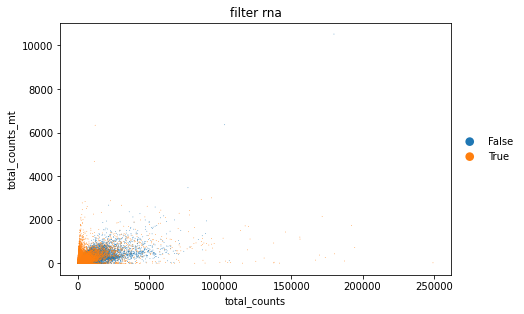

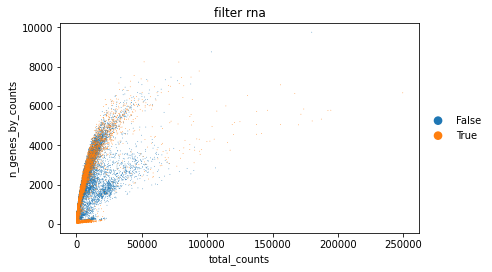

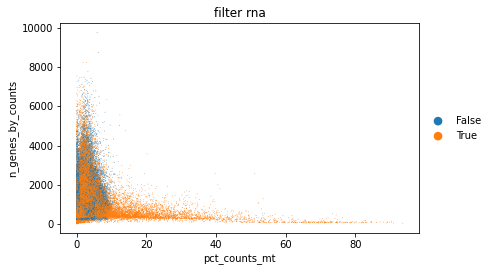

In [5]:
sc.pl.scatter(adata, x='total_counts', y='total_counts_mt', color = 'filter_rna')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color = 'filter_rna')
sc.pl.scatter(adata, x='pct_counts_mt', y='n_genes_by_counts', color = 'filter_rna')

In [6]:
pd.crosstab(adata.obs['is_doublet'], adata.obs['sample_id'])

sample_id,LN2_VSV,LN2_naive,LN_VSV,LN_naive,Men2_VSV,Men2_naive,Men_VSV,Men_naive
is_doublet,,,,,,,,
False,9556,9150,7001,9233,6925,4437,2825,1348
True,1228,250,571,465,449,280,6,72


In [7]:
# cell cycle scoring
tools.cell_cycle_scoring(adata, human = False)
adata

AnnData object with n_obs × n_vars = 53796 × 29836
    obs: 'sample_id', 'condition', 'site', 'sequencing_batch', 'scrublet_score', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'gmm_pct_count_clusters_keep', 'is_doublet', 'filter_rna', 'S_score', 'G2M_score', 'phase'
    uns: 'filter_rna_colors'
    layers: 'counts'

In [8]:
adata.write_h5ad('h5ad/combined_raw.h5ad', compression = 'gzip')

/home/jovyan/my-conda-envs/dandelion/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'phase' as categorical
